In [1]:
#importing the libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
import seaborn as sns 

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [2]:
#reading the csv files
weather_df = pd.read_csv('delhi_dewpoint.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,dewpoint
datetime_utc,
1996-11-01 11:00:00,9.0
1996-11-01 12:00:00,10.0
1996-11-01 13:00:00,11.0
1996-11-01 14:00:00,10.0
1996-11-01 16:00:00,11.0


In [3]:
#printing data types
weather_df.dtypes

dewpoint    float64
dtype: object

In [4]:
weather_df.index.dtype
#<M8[ns] is a specific dtype of datetime

dtype('<M8[ns]')

In [5]:
#weather_df.index = pd.to_datetime(weather_df.index)
#printing the index
weather_df.index

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)

In [6]:
# Data Cleaning 
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    percent = percent*100
    
    print('Count of missing data : \n',total)
    print('% of missing data : \n',percent)

list_and_visualize_missing_data(weather_df)

Count of missing data : 
 dewpoint    621
dtype: int64
% of missing data : 
 dewpoint    0.614912
dtype: float64


In [7]:
# Fill missing data with forward fill
weather_df.ffill(inplace=True)
print('Count of missing data : ',weather_df[weather_df.isnull()].count())

Count of missing data :  dewpoint    0
dtype: int64


In [8]:
weather_df.describe()

,dewpoint
count,100990.000000
mean,15.735291
std,7.061785
min,-24.000000
25%,10.000000
50%,15.000000
75%,22.000000
max,75.000000


In [9]:
#since max temperature 90 seem unrealistic and unrelatable to other values , it is assumed as outlier and thus removed
#weather_df = weather_df[weather_df.humidity <= 100]
weather_df.describe()

,dewpoint
count,100990.000000
mean,15.735291
std,7.061785
min,-24.000000
25%,10.000000
50%,15.000000
75%,22.000000
max,75.000000


In [10]:
weather_df.head()

,dewpoint
datetime_utc,
1996-11-01 11:00:00,9.0
1996-11-01 12:00:00,10.0
1996-11-01 13:00:00,11.0
1996-11-01 14:00:00,10.0
1996-11-01 16:00:00,11.0


array([<AxesSubplot:xlabel='datetime_utc'>], dtype=object)

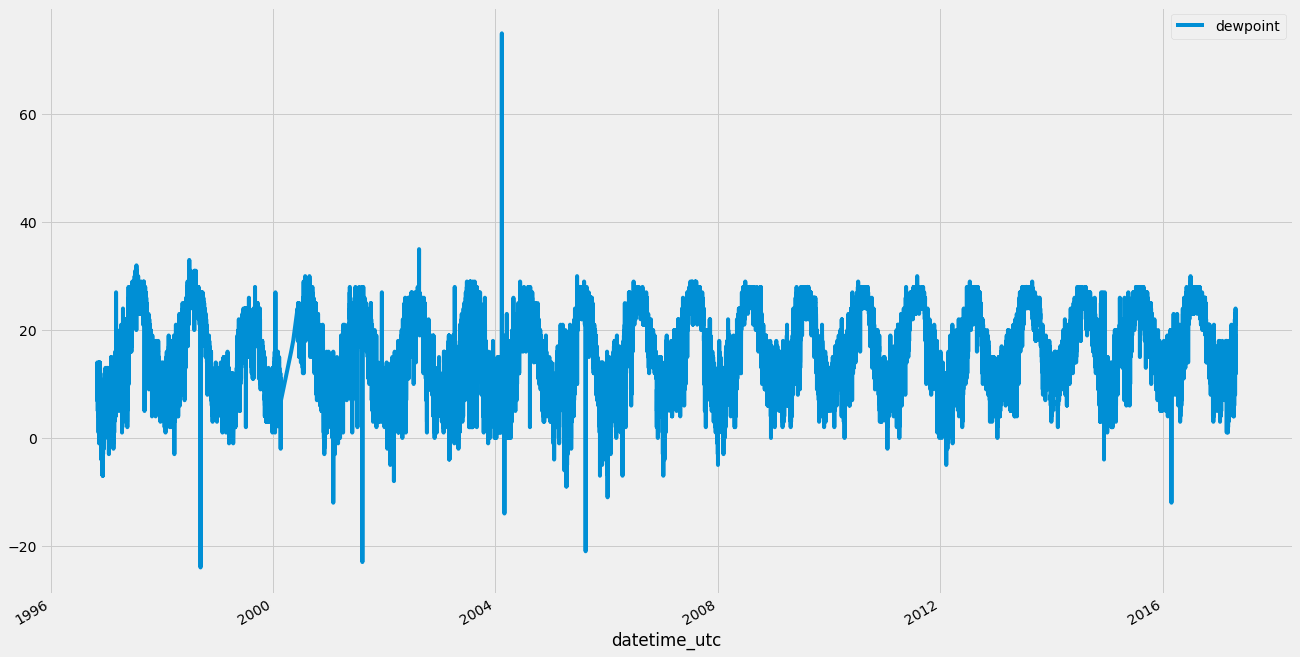

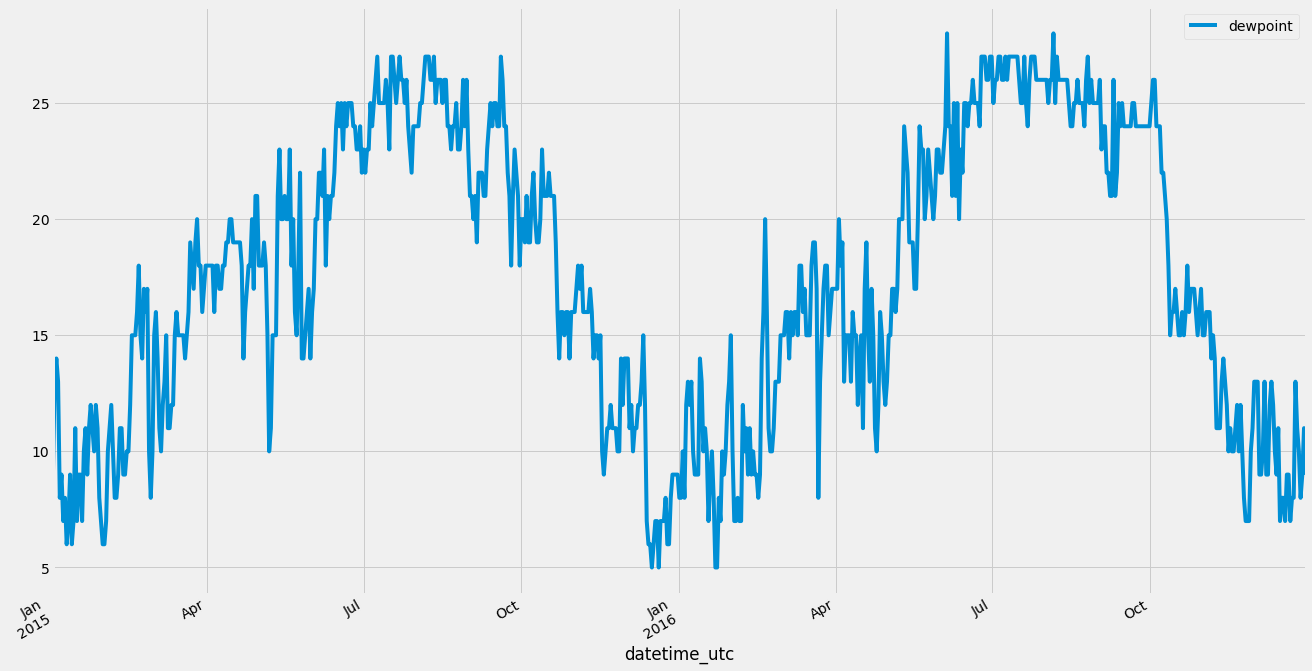

In [11]:
# to visualize trend and seasonality of weather
weather_df.plot(subplots=True, figsize=(20,12))
#detailed view of year 2015
weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

In [12]:
# splitting the dataset into training and testing set
train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')

In [13]:
train_df.head()

,dewpoint
datetime_utc,
2000-01-31,9.173661
2000-02-29,9.808102
2000-03-31,9.808102
2000-04-30,16.000000
2000-05-31,18.000000


In [14]:
train_df.describe()

,dewpoint
count,192.000000
mean,16.173222
std,6.179003
min,6.079710
25%,10.773047
50%,15.377637
75%,22.007804
max,26.581731


In [15]:
test_df.head()

,dewpoint
datetime_utc,
2016-01-31,11.328165
2016-02-29,11.987277
2016-03-31,16.036093
2016-04-30,13.246187
2016-05-31,19.246094


In [16]:
test_df.describe()

,dewpoint
count,16.000000
mean,16.666324
std,5.580855
min,11.328165
25%,12.134515
50%,13.608740
75%,20.418956
max,26.323108


In [17]:
# vizualising various parameters such as rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(12).mean()
    rolling_std = ts.rolling(12).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

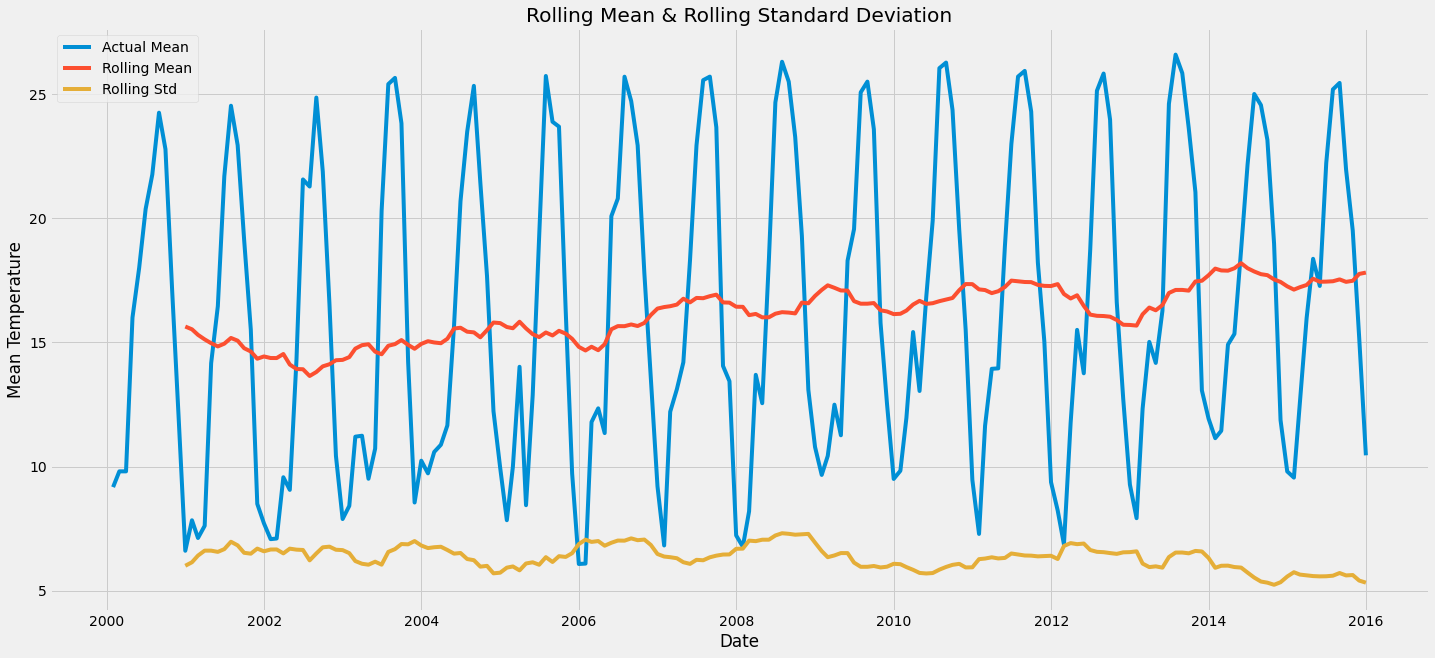

In [18]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_df.dewpoint)

In [19]:
model = pm.auto_arima(train_df, seasonal=True, m=12)

/home/niwedita/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/niwedita/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/niwedita/.local/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
/home/niwedita/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:994: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/niwedita/

In [20]:
forecast = model.predict(n_periods=len(test_df))

In [21]:
forecast = pd.DataFrame(forecast,index = test_df.index,columns=['Prediction'])

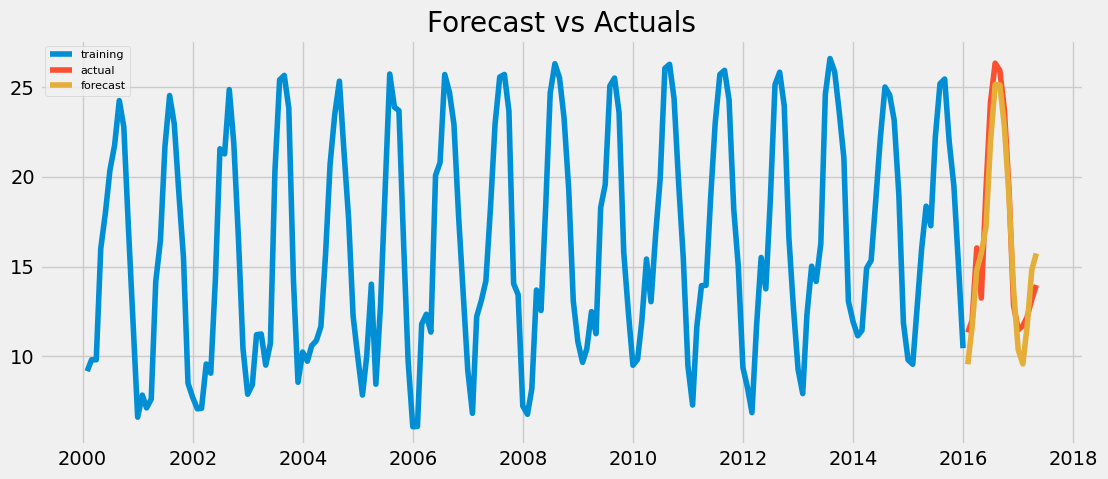

In [22]:
#  Ploting the graph
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(forecast, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

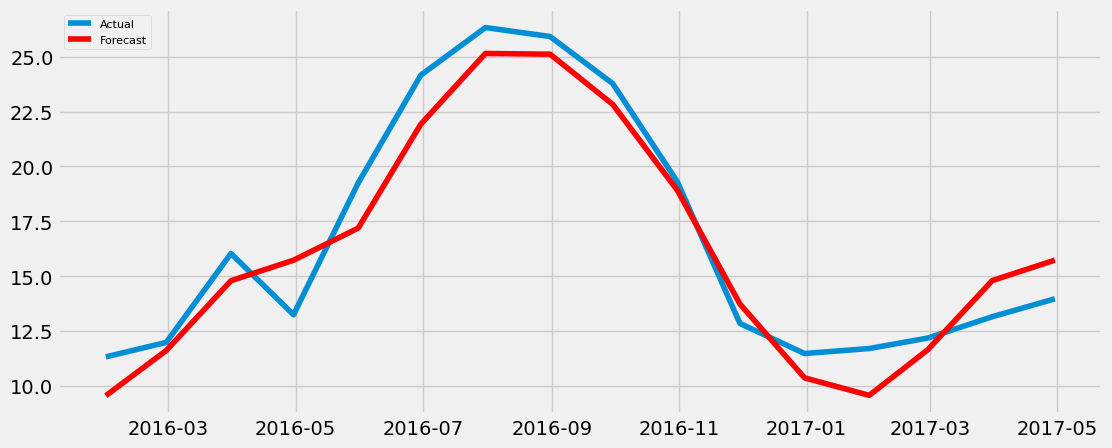

In [23]:
# Ploting Testing and Forecasted data
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_df, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [24]:
# Printing the error of model created
error = mean_squared_error(test_df, forecast)
print('Test Mean Squared Error: ',error)

Test Mean Squared Error:  2.245820662235592
